
<h2 style="text-align: center;"><b>Week 7. Transfer Learning</b></h3>

As you already know, in modern computer vision tasks—whether it’s object detection, pattern recognition, (semantic) segmentation, image classification, or others—**convolutional neural networks** (**CNNs**) are being used with increasing frequency.

They demonstrate excellent performance, supported both by a solid [mathematical foundation]((https://stats.stackexchange.com/questions/269854/are-there-mathematical-reasons-for-convolution-in-neural-networks-beyond-expedie) and by heuristics developed through extensive empirical experience.

In this assignment, you will explore the architectures of *AlexNet*, *VGG*, and *Inception*, and apply the technique of **Transfer Learning** to each of these models.

Transfer Learning is the process of fine-tuning a neural network on new data, when that network has already been pre-trained on another, typically large and well-curated dataset (for example, [ImageNet](http://www.image-net.org/), which contains around 14 million images).

<h2 style="text-align: center;"><b>VGG</b></h3>


<h2 style="text-align: center;"><b>Inception v1</b></h3>

<h2 style="text-align: center;"><b>Transfer Learning</b></h3>

Now let’s move on to how we can leverage pre-trained neural networks to accelerate our work.

Let’s first recall the general architecture of a Convolutional Neural Network (**CNN**):

<img src="https://drive.google.com/uc?id=14pApKqQjnmWMXazY0HHjREn9rI9uwCQg">

Through the operations of *convolution* and *pooling*, everything that precedes the *classification* stage essentially **extracts features from the input objects** (in this case, images). In other words, instead of manually designing features to make the classifier work well, we let the neural network learn and extract them automatically.

**Question (creative):** What kinds of features come to mind for images? (Assume the images are color (3 channels) and all have the same dimensions.)

Answer: <\Your thoughts>

<h2 style="text-align: center;"><b>Method Description</b></h3>

Now, let’s imagine that you have your own dataset and want to train a network to classify the objects in your collection.
There are four possible approaches to this task:

* **1. Build your own neural network**  
    * Unless your name is Ian Goodfellow, Geoffrey Hinton, or Andrew Ng, this approach is generally **not recommended**.  
    * May the force be with you.

* **2. CNN as a feature extractor**  
    * Take a network pre-trained on ImageNet.  
    * Remove the last fully-connected (FC) layers responsible for classification. The weights of the previous layers are **frozen**; we do not modify them. Now, the network outputs not class labels, but the activations that were fed into the FC layers (a flattened HxWxNUM_FILTERS tensor from the last layer before FC).  
    * Run the network on the new dataset to obtain the outputs for all objects—these are the features extracted by the network.  
    * Train a classifier on these features (for example, your own fully-connected network).  
    * Now we have a network that performs well on our dataset.

* **3. Fine-tuning a CNN**  
    * Take a network pre-trained on ImageNet.  
    * Remove the last fully-connected (FC) layers responsible for classification.  
    * Now, perform backpropagation on some of the earlier layers (unfreeze their weights) to adjust them to the new data. You can fine-tune the entire network, but often the first layers are kept frozen, as they are expected to capture more general features. Training the entire network also takes longer than fine-tuning just a few layers. The choice depends on the level of performance you want to achieve.  
    * Now the network outputs not class labels, but the activations that were fed into the FC layers (the weights of the last—or all—layers have been adapted to our data).  
    * Train a classifier on these features (for example, your own fully-connected network).  
    * Now we have a network that performs well on our dataset.


* **4. Use a pre-trained model "out of the box"**  
    * That is, take an already trained neural network and use it (its parameters (W, b, etc.), since the network is defined by its parameters if the architecture is known) to solve your own task. For example, [here](https://github.com/BVLC/caffe/wiki/Model-Zoo) people often share model weights trained for their specific tasks.


Depending on the quantity and nature of your data, there are **several Transfer Learning strategies** to consider:

* *You have **a small dataset** (≤ 10k) that is **similar** to the data the network was originally trained on*  
If the data is very similar, you can try using the pre-trained model as is. If the performance is not satisfactory, then use the CNN as a feature extractor and train your own classifier on these features (the second approach described above). Since the data resembles the original training data, the high-level features extracted from the last layers of the network should be informative. Performing Fine-Tuning (the third approach) in this case may lead to overfitting because the dataset is small.

* *You have **a small dataset** (≤ 10k) that is **not similar** to the data the network was originally trained on*  
This is the most challenging scenario. Here, we cannot expect the outputs of the last layers to be informative for the new data. The recommended approach is still the second one, but use the outputs from earlier layers as features, since, as we know, they are expected to capture more general patterns in the data.

* *You have **a large dataset** (≥ 10k) that is **similar** to the data the network was originally trained on*  
In this case, you can safely perform Fine-Tuning (the third approach) if the "out-of-the-box" model does not give satisfactory results. Since the dataset is large, the risk of overfitting is lower. It makes sense to unfreeze the weights of the last few layers (depending on your time and computational resources, you could also unfreeze the entire network).

* *You have **a large dataset** (≥ 10k) that is **not similar** to the data the network was originally trained on*  
The approach is essentially the same as for similar data: fine-tune almost the entire network. However, you are free in this case to completely change all parameters (and hyperparameters) of the network, since you are essentially only using its architecture, disregarding its prior training. Often, though, the pre-trained weights are retained as an initialization for training on the new data.


We hope that this gives you a clearer understanding of how to train powerful networks on new data.

<h2 style="text-align: center;"><b>Let’s move on to the practical part.</b></h3>


<p style="text-align: center;"><i>(based on http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)</i></p>

In [ ]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

/tmp/ipython-input-1691537879.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### What the assignment entails

You will work with convolutional neural network architectures—**AlexNet (provided for you in the example), VGG16, Inception_v3**—using them as a *Feature Extractor*, with *Fine Tuning*, and *"out of the box"*.

**For each approach, you need to:**
- Plot the loss curves for both the training and validation datasets
- Report the model’s performance (accuracy)

### Data  

In this assignment, we use networks from the **torchvision** library that are pre-trained on the ImageNet dataset.  
As the new data, you will use the Ants vs. Bees dataset, which you can download here: **[Ants vs. Bees](https://download.pytorch.org/tutorial/hymenoptera_data.zip)**.  
This dataset is a subset of ImageNet and contains 400 images in total, with approximately 250 for training and 150 for validation (test).

### Functions for Model Training and Visualization:

* Load the data:


In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2025-11-05 06:04:15--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.164.154.37, 18.164.154.30, 18.164.154.123, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.164.154.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  --.-KB/s    in 0.1s    

2025-11-05 06:04:15 (349 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_dat

In [ ]:
# Transform the training data for data augmentation and normalization
# For the validation (test) dataset, apply normalization only

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Data folder. If you are running in Colab, you need to copy the data to your directory and mount the drive.
# If running locally, simply download the dataset.
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# Special class for loading data in batches
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Dataset sizes for training and validation:

In [ ]:
print(dataset_sizes)

{'train': 244, 'val': 153}


**Question (to check understanding of the code above):**  
1. In the `DataLoader()` above, `shuffle=True` is used. What is its purpose?  
2. How many images will be in each batch?

**Answer:** <`Your answer`>

Answer:

1. shuffle=True is used to randomly shuffle the data at each epoch.
2. batch_size=4 parameter means there will be 4 images in each batch.

* Let’s take a look at some images from the dataset:

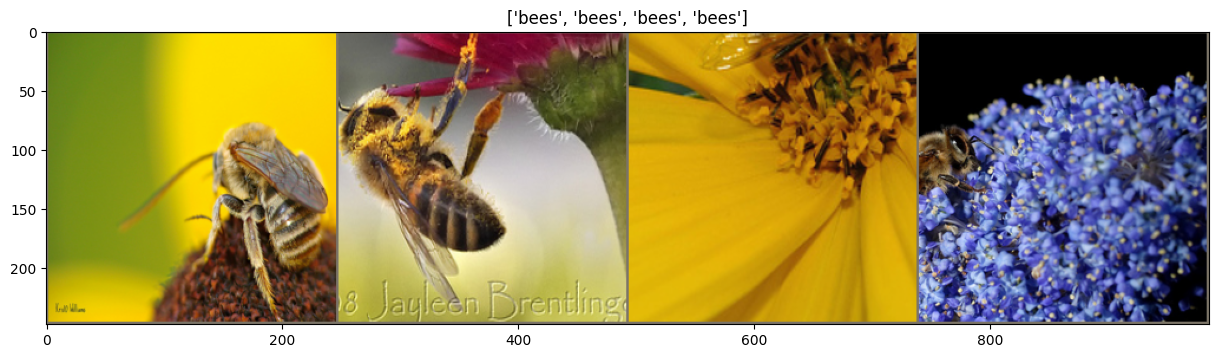

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get one batch (images and labels) from the training dataset
inputs, classes = next(iter(dataloaders['train']))

# Arrange the images side by side
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
for i in dataloaders['train']:
    print(i[0][0])
    break

tensor([[[-0.2856, -0.3027, -0.3541,  ...,  2.2147,  2.1975,  2.1975],
         [-0.2513, -0.2342, -0.3541,  ...,  2.2147,  2.1975,  2.1975],
         [-0.3027, -0.3027, -0.2856,  ...,  2.2147,  2.1804,  2.1804],
         ...,
         [ 0.9646,  0.9303,  0.9303,  ..., -0.5596, -0.4911, -0.6452],
         [ 1.0331,  1.0159,  0.9988,  ..., -0.4397, -0.3369, -0.5424],
         [ 1.0159,  1.0331,  1.0159,  ..., -0.3883, -0.3027, -0.5253]],

        [[ 0.3452,  0.3627,  0.3627,  ...,  1.6583,  1.6408,  1.6408],
         [ 0.3452,  0.3102,  0.3452,  ...,  1.6583,  1.6408,  1.6408],
         [ 0.3803,  0.3627,  0.3277,  ...,  1.6758,  1.6408,  1.6583],
         ...,
         [ 0.9230,  0.9055,  0.8880,  ..., -1.0378, -1.0203, -0.9328],
         [ 0.9580,  0.9230,  0.9055,  ..., -1.0903, -1.0553, -1.0203],
         [ 0.9755,  0.9930,  0.9930,  ..., -1.1604, -1.1078, -1.0728]],

        [[-1.3687, -1.3513, -1.3339,  ..., -1.7696, -1.7870, -1.7870],
         [-1.3861, -1.3339, -1.3513,  ..., -1

### Model training

The following function will be used for training the model. Arguments:  
* model – the neural network  
* loss – the loss function to optimize (criterion, cost function, objective)  
* optimizer – the optimization algorithm  
* scheduler – the learning rate adjustment policy  
* num_epochs – the number of training iterations

**Task**: You need to modify this function so that it also returns the arrays of losses for the training and validation datasets (so that you can later plot the curves). You can modify the function in any way, as long as it works correctly.|

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    #<Your code here>
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # each epoch has a training and testing stage
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # set the model to training mode
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

           # iterate over batches
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # get images and labels
                inputs, labels = data

                # wrap in variables
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # Initialize the parameter gradients
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # Backward pass + optimize only if it is the training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            #<Your code here>
            losses[phase].append(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # If the best performance is reached, save the model weights
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model, losses

* Function to display test images and their predictions

In [ ]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

* Function to evaluate model accuracy on the validation set

In [ ]:
def evaluate(model):
    model.eval()

    runninig_correct = 0
    for data in dataloaders['val']:
        # get images and labels
        inputs, labels = data

        # transfer to GPU, if possible
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)

        runninig_correct += int(torch.sum(predicted == labels))

    return runninig_correct / dataset_sizes['val']

### Assignment

## For each of the following neural networks:
* **AlexNet** (already done in the example)
* **VGG16**
* **Inception_v3**

Write the code and display the results (loss and accuracy plots, and an example of image classification visualization using the `visualize_model()` function) for the following three approaches:
* Using the pre-trained network **"as is"**
* Using the network as a **Feature Extractor**
* **Fine-Tuning** the network

For each approach, you should:
* Apply the corresponding method to the network ("as is", FE, or FT)
* Plot the **training** and **validation loss**
* Display the model’s **accuracy** on the validation (test) dataset
* *(Optional)* use the `visualize_model()` function

### AlexNet

<h2 style="text-align: center;"><b>AlexNet</b></h2>

**AlexNet** is a neural network that won the ILSVRC (ImageNet Large Scale Visual Recognition Challenge) in 2012 and became the foundation for many other architectures. It was first presented in the paper *“ImageNet Classification with Deep Convolutional Neural Networks”*, authored by Geoffrey Hinton – a person often called the father of modern computer vision.

The architecture is illustrated in the image below.

<img src="https://www.learnopencv.com/wp-content/uploads/2018/05/AlexNet-1.png">

**AlexNet** consists of 5 **convolutional** layers, 3 **MaxPool** layers, and 2 **Fully Connected** layers at the end. Note that in the last pooling layer, the pooling windows **overlap** because the *stride* is set to 2. This modification compared to traditional pooling helped reduce the error by 0.4%.

Essentially, **AlexNet** is the most basic convolutional network architecture after LeNet, which we implemented in the previous lesson.


*NOTE: Loss plots are not shown here, and `visualize_model()` is not used. You are expected to include them.*


Loading the model:

In [ ]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 152MB/s]


Let's see what's inside:

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can see that the classifier receives *9216 features* as input. This will be the input size for our new classifier.

* **Fine Tuning**

Let's configure the model – modify the FC layer and set the *cost function* and *optimization algorithm*:

(*By default, backpropagation is applied to all layers, so here we are only replacing the FC layer with our own classifier.*)

In [ ]:
# num_features is the dimension of the feature vector fed into the FC layer.
num_features = 9216
# Replace the Fully-Connected layer with our linear classifier.
model.classifier = nn.Linear(num_features, 2)

# whether to use the GPU
if use_gpu:
    model = model.cuda()

# We use cross entropy as the cost function.Click to apply
loss_fn = nn.CrossEntropyLoss()

# As an optimizer—stochastic gradient descent
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Multiply the learning rate by 0.1 every 7 epochs (this is one of the heuristics, not covered in the lectures)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 11s
Best val Acc: 0.915033


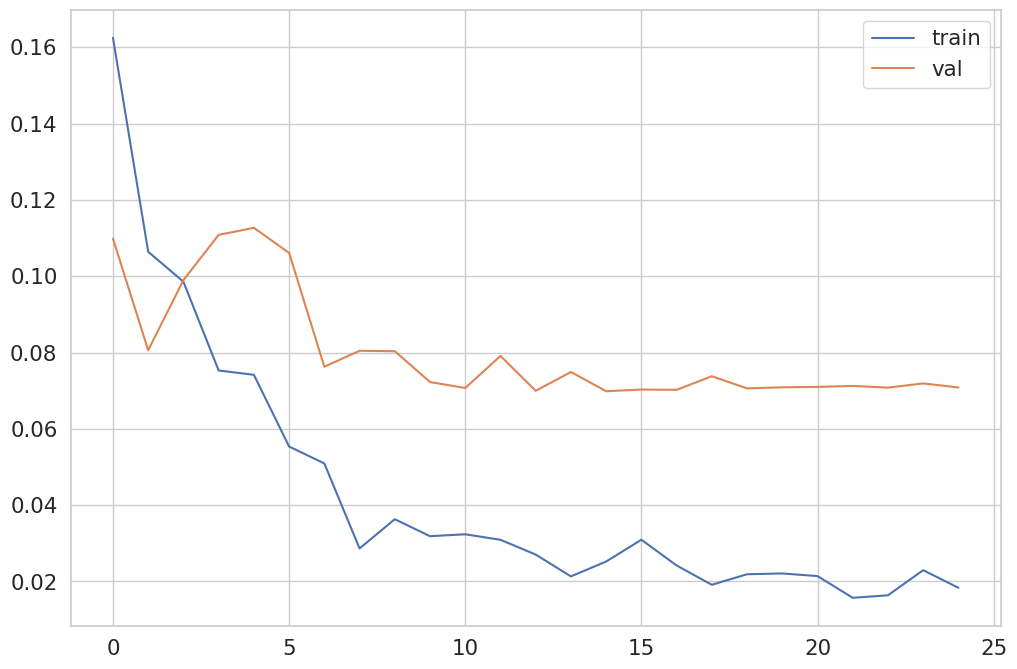

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Let's build a loss graph for training and validation

#<YOU CODE>
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [ ]:
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

<All keys matched successfully>

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.9150


* **Feature Extractor** method:

In [ ]:
model_extractor = models.alexnet(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Remember that by default all layers of the neural network are trained from scratch:

In [ ]:
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Let's make it so that backpropagation does **not** apply to them (freeze them) and replace the classifier (since the old one already has weights for ImageNet).

In [ ]:
# Freeze the parameters (weights)
for param in model_extractor.parameters():
    param.requires_grad = False

# `num_features` is the dimensionality of the feature vector entering the FC layer
num_features = 9216
# Replace the Fully-Connected layer with our linear classifier.
model_extractor.classifier = nn.Linear(num_features, 2)

# Whether to use GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# Use cross-entropy as the cost function
loss_fn = nn.CrossEntropyLoss()

# Train only the classifier
optimizer = optim.Adam(model_extractor.classifier.parameters(), lr=1e-4)

# Multiply the learning rate by 0.1 every 7 epochs (this is one of the heuristics, not covered in the lectures)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
%%time
model_extractor,losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 6s
Best val Acc: 0.901961
CPU times: user 12.4 s, sys: 4.3 s, total: 16.7 s
Wall time: 1min 5s


In [ ]:
torch.save(model_extractor.state_dict(), 'AlexNet_extractor.pth')

In [ ]:
model_extractor.load_state_dict(torch.load('AlexNet_extractor.pth'))

<All keys matched successfully>

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.8954


We can see that the accuracy is much better: ~90%.

* **Hybrid** approach:  
We will train not only the last **fully connected** layer, but also several of the preceding layers.

In [ ]:
model_mixed = models.alexnet(pretrained=True)

In [ ]:
layers_to_unfreeze = 5

# Disable gradient computation for the layers we won't train
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

num_features = 9216
model_mixed.classifier = nn.Linear(num_features, 2)

if use_gpu:
    model_mixed = model_mixed.cuda()

loss_fn = nn.CrossEntropyLoss()

# Train the last layers_to_unfreeze layers of the convolutional part and the fully connected layer
# parameters() just returns a list of parameter tensors, so you can concatenate two such lists
optimizer = optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] +
                      list(model_mixed.classifier.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
%%time
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 7s
Best val Acc: 0.895425
CPU times: user 14.4 s, sys: 4.4 s, total: 18.8 s
Wall time: 1min 6s


In [ ]:
torch.save(model_mixed.state_dict(), 'AlexNet_mixed.pth')

In [ ]:
model_mixed.load_state_dict(torch.load('AlexNet_mixed.pth'))

<All keys matched successfully>

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))

Accuracy: 0.8954


**Question 1 (important):** Why does the accuracy improve when we stop training the entire network?  
(Hint: look at the dataset and how it aligns with the four situations described above)

**Answer (important):** The accuracy improves because the dataset is small and similar to the original training data (ImageNet). Freezing the earlier layers and using the network as a feature extractor prevents overfitting on this small dataset, which would occur if the entire network was fine-tuned.



**Question 2:** Why does unfreezing the last layers not lead to an increase in accuracy, even though unfreezing a few of the last layers is usually a good solution for classifying a similar dataset? (A question to test your attention)

Answer: For this small dataset, training even a few more layers (in the "Hybrid" approach) might still lead to some overfitting compared to just training the final classifier on the frozen features (in the "Feature Extractor" method), which appears to generalize slightly better in this specific case.


## Another method

Instead of freezing all the early layers, you can reduce the gradient step for them. The optimizer interface allows you to do this.

In [ ]:
model_diff_lr = models.alexnet(pretrained=True)

model_diff_lr.classifier = nn.Linear(num_features, 2)

optimizer = torch.optim.Adam(params=[
        {"params": model_diff_lr.classifier.parameters()},
        {"params": model_diff_lr.features.parameters(), "lr": 1e-5,}
    ],
    lr=1e-4
)

criterion = nn.CrossEntropyLoss()


exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_diff_lr.to("cuda")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=2, bias=True)
)

In [ ]:
_, losses = train_model(model_diff_lr, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 12s
Best val Acc: 0.915033


In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_diff_lr)))

Accuracy: 0.9150


### Other, more modern neural networks


**Question:** Which strategy would you choose, considering the size and specificity of the new dataset?


**Answer:** Given the small size of the dataset and its similarity to ImageNet, the CNN as a feature extractor strategy is the most suitable. This approach minimizes overfitting by training only the final classifier on the features extracted from the frozen pre-trained layers.

### VGG16

A single **convolutional** layer with a 5×5 filter can be replaced by two consecutive layers with 3×3 filters, since their **receptive field** on the image will be the same. At the same time, the number of parameters decreases, making the network easier to train.

At the time VGG was created, it was already noticed that the more layers a neural network has, the higher its accuracy. By replacing large filters with several 3×3 filters, researchers obtained a deep network with fewer parameters. The architecture of VGG-16 (the VGG version with 16 layers) is shown in the image below:

<img src="https://cdn-images-1.medium.com/max/1040/1*0Tk4JclhGOCR_uLe6RKvUQ.png">

When people refer to **VGG**, they usually mean **VGG-16** or **VGG-19**. There are no deeper versions of **VGG**, as accuracy starts to drop after 19 layers.

To achieve high results in competitions, additional tricks were used during training and validation, which you can read about in more detail in [this Medium article](https://medium.com/coinmonks/paper-review-of-vggnet-1st-runner-up-of-ilsvlc-2014-image-classification-d02355543a11).

In [ ]:
# <YOU CODE>
model_extractor = models.vgg16(pretrained=True)

# Freeze the parameters (weights)
for param in model_extractor.parameters():
    param.requires_grad = False

num_features = 25088
model_extractor.classifier = nn.Linear(num_features, 2)

if use_gpu:
    model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

# Train only the classifier
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 73.8MB/s]


In [ ]:
# Start the training

model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 43s
Best val Acc: 0.947712


In [ ]:
torch.save(model_extractor.state_dict(), 'VGG16.pth')

In [ ]:
model_extractor.load_state_dict(torch.load('VGG16.pth'))

<All keys matched successfully>

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9477


### Inception_v3

### Let's look at the idea that motivated researchers to create this architecture.

The area occupied by a classifiable object can vary greatly. Example shown in the image below:

<img src="https://cdn-images-1.medium.com/max/1040/1*aBdPBGAeta-_AM4aEyqeTQ.jpeg">

* To extract information from a large area, **large** filters work best, and conversely, for small objects, **small** filters are better.  
* Deep neural networks are much harder to train: they suffer from **vanishing gradients** and tend to **overfit**.  

To address the first problem, researchers came up with the **Inception** module, which applies filters of different sizes and then concatenates the resulting channels. This allows extracting information from both large and small objects. A basic implementation of the module looks like this:

<img src="https://cdn-images-1.medium.com/max/1040/1*DKjGRDd_lJeUfVlY50ojOA.png">

The implementation can be made more efficient by first reducing the number of channels using a **1×1 convolutional layer**, and then applying a **5×5 filter layer**. The computational savings occur because we first **reduce the dimensionality** of the data before transforming it. Advanced implementation:

<img src="https://cdn-images-1.medium.com/max/1040/1*U_McJnp7Fnif-lw9iIC5Bw.png">

The network consists of a **root** (several convolutional layers) followed by **Inception** modules. The root is highlighted in orange, and the **auxiliary classifiers** in purple. They help address the second problem mentioned earlier. Our loss function is a weighted sum of the **LogLoss** from the two **auxiliary classifiers** and the **main classifier** at the end of the network.

<img src="https://cdn-images-1.medium.com/max/1040/1*uW81y16b-ptBDV8SIT1beQ.png">

After Inception v1, versions 2, 3, and 4 were introduced. You can read more about them in [this Medium article](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202).


In [ ]:
# We need to resize the images to 299, otherwise there will be an error because the dimensionality becomes negative.
# This is due to the network originally being trained on 299×299 images.

# The resulting image size is determined by the transformations

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# The dataset object
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# A special class for loading data in batches
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}

In [ ]:
model_extractor = models.inception_v3(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 200MB/s]


In [ ]:
model_extractor.AuxLogits.fc = nn.Linear(768, 2)
model.fc = nn.Linear(2048, 2)

In [ ]:


num_features = 25088
model_extractor.classifier = nn.Linear(num_features, 2)

if use_gpu:
    model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_extractor.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
%%time
model_extractor.aux_logits = False
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 3m 12s
Best val Acc: 0.941176
CPU times: user 2min 33s, sys: 6.59 s, total: 2min 40s
Wall time: 3min 11s


In [ ]:
torch.save(model_extractor.state_dict(), 'Inceptionv3.pth')

In [ ]:
model_extractor.load_state_dict(torch.load('Inceptionv3.pth'))

<All keys matched successfully>

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9281


**Question:** Which of the networks turned out to be the best? Why do you think so?

**Answer:** VGG16 with the Feature Extractor approach was the best with highest accuracy 0.9477. This could be because its architecture was effective at extracting relevant features for this dataset, and the Feature Extractor method prevented overfitting on the small dataset.

### ResNet

The next idea addresses the problem of vanishing gradients. The more layers there are, the worse the gradients propagate during backpropagation.

$$
\frac{\partial F}{\partial w_1} \times \frac{\partial F}{\partial w_2} \times \dots \times \frac{\partial F}{\partial w_n}
$$

Therefore, we can "pass" them to deeper layers using residual connections. This allows us to build DEEPER networks...

![](https://www.machinelearningmastery.ru/img/0-145407-381989.png)


### ResNeXt

Here we face a problem. We again have only a single path for the features. Let's try to combine the ideas from the last two sections.

![](https://www.programmersought.com/images/955/19ca8284fafed90cdfbdc9b103ae064b.png)

So, let's introduce another dimension — the number of paths. In the original paper, it is called cardinality.

$$
\mathcal{F}(\mathbf{x}) = \sum_{i=1}^{C} \mathcal{T}_{i}(\mathbf{x})
$$

Now let's think about how to optimize such an architecture in terms of computation.

![](https://miro.medium.com/max/1000/1*cIm3uy7eNvEchxRbBeBScQ.png)

The top image is very informative. All three blocks are mathematically equivalent. Let's look at the transition from (a) -> (b):  
Instead of summing large tensors at the end, let's just concatenate small ones along the channel dimension. Then we apply a 1×1 convolution once.

(b) -> (c):

The second transition requires a bit more mental effort. First, let's understand what a group convolution is. In a standard convolutional layer, the following happens:

![](https://blog.yani.ai/assets/images/posts/2017-08-10-filter-group-tutorial/convlayer.svg)

The feature tensors before and after the convolution are shown in gray, and the convolution kernels themselves are in yellow. One "strip" of these kernels corresponds to one channel of the output tensor. Thus, in each strip there are $c_1$ convolutions, and there are $c_2$ strips in total. The number of parameters in this case is $N_1 = c_1 \cdot c_2$.

Let's remember this number.

Now let's split the input and output tensors into two parts:

![](https://blog.yani.ai/assets/images/posts/2017-08-10-filter-group-tutorial/filtergroups2.svg)

Next, we try to map the first half of the input tensor to the first half of the output. For this, we need $c_2 / 2$ strips of length $c_1 / 2$. We do the same for the remaining halves. Now the magic: how many parameters do we have in the end?  

$$
N_2 = 2 \cdot (c_1/2 \cdot c_2/2) < c_1 \cdot c_2 = N_1
$$

[About group convolutions.](https://blog.yani.ai/filter-group-tutorial/)

[Original ResNeXt paper](https://arxiv.org/pdf/1611.05431.pdf)


## EfficientNet

Moving on, let's talk about efficiency in more detail. Previously, network architectures were essentially **hand-designed**. For example, we have ResNet50 instead of ResNet54, and convolutions of size 3×3 instead of 4×4.

However, if we have enough resources, we can try to train an algorithm to select the optimal layer parameters. First, we need to define methods for scaling the network and run a grid search:

![](https://1.bp.blogspot.com/-Cdtb97FtgdA/XO3BHsB7oEI/AAAAAAAAEKE/bmtkonwgs8cmWyI5esVo8wJPnhPLQ5bGQCLcBGAs/s640/image4.png)

Then, based on these data, we can obtain the optimal architecture for a given number of parameters:

![](https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s640/image2.png)

It turns out that even the smallest network will deliver better results.

![](https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s640/image3.png)

Read more [here](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html).


In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=1d80cd0d6fd57f1883c64394d412c8231b92b1524a9090ca90eed615a08f27a1
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


100%|██████████| 35.1M/35.1M [00:00<00:00, 116MB/s]

Loaded pretrained weights for efficientnet-b2
